* Modélisation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
data = pd.read_csv("df_final.csv")
data.shape

/tmp/ipykernel_3303/1621852662.py:1: DtypeWarning: Columns (1,19,20,21,22,34,39,40,41,42,43,49,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("df_final.csv")


(5017137, 54)

In [6]:
df = data.copy()

Isolation des variables météorologiques ayant un effet sur la variable incendie (isolées précédemment).
Création de la matrice de design X et la taget y.

In [33]:
df_prediction = df[['dd','ff','t','td','precip','hu', 'incendie']]
print(df_prediction.shape)
df_prediction = df_prediction.dropna()
print(df_prediction.shape)
X = df_prediction[['dd','ff','t','td','precip','hu']]
y = df_prediction['incendie']
y.sum()

(5017137, 7)
(2019491, 7)


898

Le nombre de variables explicatives étant faible, il est possible de ne garder que les lignes sans NaN en gardant largement suffisamment de données (2 millions de données dont 898 incendies)

Séparation de la base en données de test et d'entraînement

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Créer et entraîner le modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Création du modèle de régression logistique. Le pre-processing est un Standard Scaler permettant de standardiser les données. L'option class_weight = 'balanced' permet de pondérer les classes et ainsi de prendre en compte la sous-représentation de la classes incendie dans les données par rapport à la classe "pas d'incendie". En effet, sans cette option, le modèle renvoie toujours 0 car il a alors une excellente accuracy bien qu'il n'ait rien appris.

In [77]:
model = Pipeline([('scaler',StandardScaler()),
                      ('classi',LogisticRegression(class_weight='balanced'))]
                )
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classi', LogisticRegression(class_weight='balanced'))])

Prédiction du fait qu'il y ait un incendie sur les données météo de test

In [78]:
ypred = model.predict(X_test)
print(confusion_matrix(y_test, ypred))

[[283299 120424]
 [    43    133]]


La confusion matrix permet de regarder en détail comment ont été classées les données de test par le modèles. Sur les données sans incendies, environ 280 000 ont été bien classifiées contre 120 000 mal classifiées. Sur les données avec incendie, 133 ont été bien classifiées contre 43 mal classifiées. Le modèle a réussi a reconnaître des conditions météo propices aux incendies. La classification ne peut de toute façon pas être excellente car la météo ne détermine pas totalement le fait qu'il y ait un incendie (par exemple, un même jour il y aura les mêmes conditions météo dans deux communes mais un incendie ne va se déclarer que dans l'une des deux).

On regarde désormais plus en détail les probabilités d'incendie trouvées par le modèle.

In [79]:
proba0 = model.predict_proba(X_test[y_test==0])
proba1 = model.predict_proba(X_test[y_test==1])

On trace l'histogramme des probalitités d'incendie prédites par le modèle sur les données pour lesquelles il n'y avait pas d'incendie.

(array([2.68142469e-02, 8.38258467e-01, 1.93964739e+00, 2.81950553e+00,
        2.96861280e+00, 2.96159598e+00, 2.91648790e+00, 2.55888108e+00,
        2.36742234e+00, 2.13737114e+00, 1.99678429e+00, 1.91609095e+00,
        1.74016945e+00, 1.80933517e+00, 1.63491726e+00, 1.77124390e+00,
        1.59356819e+00, 1.51087004e+00, 1.36151218e+00, 1.48405580e+00,
        1.44421033e+00, 1.36827839e+00, 1.17230885e+00, 1.29259706e+00,
        1.19135448e+00, 1.18534007e+00, 1.23094935e+00, 1.16028003e+00,
        1.11617435e+00, 1.09061311e+00, 1.19235689e+00, 1.01417997e+00,
        1.05552905e+00, 9.88869331e-01, 1.09813112e+00, 1.06981327e+00,
        1.03447861e+00, 9.33737234e-01, 1.14399100e+00, 8.87376153e-01,
        8.81862943e-01, 1.00490776e+00, 1.13647299e+00, 8.95395367e-01,
        9.59799680e-01, 9.64059887e-01, 9.63809287e-01, 8.93891764e-01,
        9.15944603e-01, 8.13699624e-01, 9.22710815e-01, 8.92638762e-01,
        8.73342528e-01, 9.45264854e-01, 7.86384176e-01, 9.460166

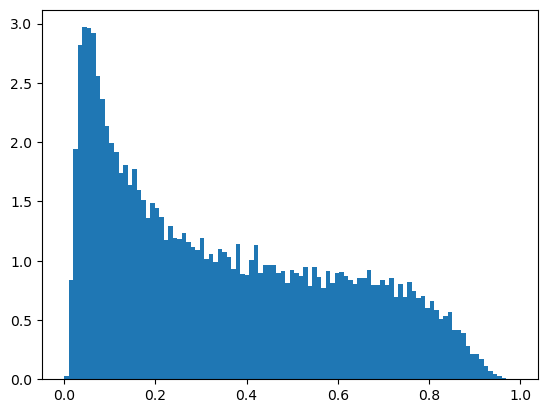

In [64]:
plt.hist(proba0[:,1], density=True, bins=100)

On remarque que même si beaucoup de données sont mal classifiées (p>0.5), les probabilités trouvées sont bien proches de 0 pour la plupart.

On regarde désormais les probabilités prédites sur les données pour lesquelles il y a eu un incendie (moins de données).

(array([0.24665898, 0.        , 0.        , 0.24665898, 0.49331797,
        0.36998848, 0.98663593, 0.49331797, 1.10996543, 1.4799539 ,
        0.86330644, 1.10996543, 1.35662441, 1.23329492, 1.10996543,
        2.71324882, 2.09660136, 3.32989628, 1.4799539 , 0.98663593]),
 array([0.05101952, 0.09708975, 0.14315998, 0.18923021, 0.23530044,
        0.28137067, 0.3274409 , 0.37351113, 0.41958136, 0.4656516 ,
        0.51172183, 0.55779206, 0.60386229, 0.64993252, 0.69600275,
        0.74207298, 0.78814321, 0.83421344, 0.88028368, 0.92635391,
        0.97242414]),
 <BarContainer object of 20 artists>)

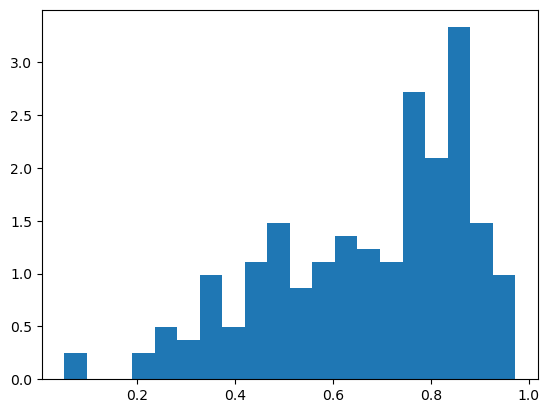

In [66]:
plt.hist(proba1[:,1], density=True, bins=20)

De la même façon, si des données sont mal classifiées (p<0.5), les probabilités trouvées sont plutôt proches de 1 pour la plupart.

Le modèle réussit alors à capter des influences des variables météorologiques sur le risque d'incendie

Etudions maintenant les coefficients de la régression logistique

In [85]:
coeffs = pd.DataFrame(data= model.named_steps['classi'].coef_, columns = X.columns, index=['coefficient'])
coeffs

,dd,ff,t,td,precip,hu
coefficient,0.023002,0.250419,-1.105582,1.515885,0.081197,-1.753249


Les coefficients peuvent être comparés entre eux grâce à la standardisation des données. Plus la valeur absolue du coefficient est grande, plus la variable influe sur la probabilité d'être classifié en incendie. Un signe positif (resp. négatif) indique une relation croissante (resp. décroissante) entre la variable et le risque d'incendie.

Les variables les plus importantes semblent êtres l'humidité (hu) et les variables de température (t, td).

Notons un point surprenant : le coefficient associé à la température moyenne sur la journée (t) est négatif alors que cette variable est corrélée positivement à la variable incendie comme vu précédemment. Ceci est du au fait que la corrélation de t et td est de 0.9 donc il y a un effet de compensation entre le coefficient positif de td et le coefficient négatif de t. Pour avoir un modèle causal, il faudrait peut-être supprimer l'une des deux variables.

In [ ]:
# Obtenir les probabilités sur l'ensemble de test
probabilities = model.predict_proba(X_test)

# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_test, probabilities[:, 1])  # Utiliser les probabilités de la classe 1 (incendie)
print(f'AUC-ROC: {auc_roc}')

In [ ]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

In [ ]:
evalutation(model)

In [70]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = Pipeline([('scaler',StandardScaler()),
                      ('classi',AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=10,
    algorithm="SAMME.R",
    learning_rate=0.5
))]
                     )
ada.fit(X_train, y_train)

# Obtenir les probabilités sur l'ensemble de test
proba0_ada = ada.predict_proba(X_test[y_test==0])
proba1_ada = ada.predict_proba(X_test[y_test==1])

ypred = ada.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

#evaluation(rf)

[[403723      0]
 [   176      0]]


/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    403723
           1       0.00      0.00      0.00       176

    accuracy                           1.00    403899
   macro avg       0.50      0.50      0.50    403899
weighted avg       1.00      1.00      1.00    403899



/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
